In [1]:
import re
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
pattern1 = r"Train BCE: (-?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)"
pattern2 = r"\[Metrics\] wlogloss: (-?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?) - AUC: (-?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?) - logloss: (-?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)"
pattern3 = r"Train loss: (-?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)"

In [2]:
def parse_log(curr_name,path):
    
    with open(path,'r') as f:
        logs = f.readlines()

    bce = []
    wlogloss, auc, logloss = [], [], []
    train_loss = []
    for line in logs:
        match1 = re.search(pattern1, line)
        match2 = re.search(pattern2, line)
        match3 = re.search(pattern3, line)
        if match1:
            bce.append(float(match1.group(1)))
        if match2:
            wlogloss.append(float(match2.group(1)))
            auc.append(float(match2.group(2)))
            logloss.append(float(match2.group(3)))
        if match3:
            train_loss.append(float(match3.group(1)))
    return {
        'name':curr_name,
        'train_bce': bce,
        'wlogloss': wlogloss,
        'auc': auc,
        'logloss': logloss,
        'train_loss': train_loss

    }


In [3]:
ret_dict2= parse_log('Twitter','../../Criteo/DCNv2_criteo_x1/criteo_x1/combined_pair_posw0.1_logloss.log')
ret_dict4 = parse_log('Base','../../Criteo/DCNv2_criteo_x1/criteo_x1/bce_posw0.1_logloss.log')

combined_pair_logloss_tuner_path = '../../Criteo/combined_pair_logloss_tuner/criteo_x1/'
bce_logloss_tuner_path= '../../Criteo/bce_logloss_tuner/criteo_x1/'
combined_pair_ret_dicts = [parse_log(a,b) for (a,b) in zip([0.2,0.4,0.6,0.8,1.0],np.sort([combined_pair_logloss_tuner_path+_ for _ in os.listdir(combined_pair_logloss_tuner_path) if '.log' in _]))]
bce_ret_dicts = [parse_log(a,b) for (a,b) in zip([0.2,0.4,0.6,0.8,1.0],np.sort([bce_logloss_tuner_path+_ for _ in os.listdir(bce_logloss_tuner_path) if '.log' in _]))]

In [4]:
def mv_step(arr, step, window):
    ret = []
    for i in range(0,len(arr),step):
        if i ==0: continue
        else:
            ret.append(np.mean(arr[i-window+1: i+1]))
    return ret

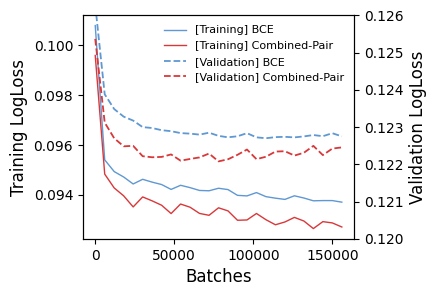

In [5]:
twitter_color = '#D9383A'
base_color = '#5F98D2'
jrc_color='#96C37D'
# [-2]-> validation; [-1]->test
fig, ax1 = plt.subplots(figsize=(3.5,2.9))
x4 = np.array(range(len(ret_dict4['wlogloss'])))*1000
x2 = np.array(range(len(ret_dict2['wlogloss'])))*1000
jump = 6
line1, = ax1.plot(x4[:-2][::jump], mv_step(ret_dict4['train_bce'],step=1000,window=1000)[::jump], label='BCE [Train]', ls='solid',color=base_color, linewidth=1)
line2, = ax1.plot(x2[:-2][::jump], mv_step(ret_dict2['train_bce'],step=1000,window=1000)[::jump], label='Combined-Pair [Train]', ls='solid', color=twitter_color, linewidth=1)

ax1.set_ylabel('Training LogLoss',fontdict={'size':12})
ax2 = ax1.twinx()
line3, = ax2.plot(x4[:-2][::jump], ret_dict4['wlogloss'][:-2][::jump], label='BCE [Train]', ls='dashed', color=base_color, linewidth=1.3)
line4, = ax2.plot(x2[:-2][::jump], ret_dict2['wlogloss'][:-2][::jump], label='Combined-Pair [Train]', ls='dashed', color=twitter_color, linewidth=1.3)
ax2.set_ylabel('Validation LogLoss',fontdict={'size':12})
# ax1.set_ylim(0.120,0.126)
ax2.set_ylim(0.120,0.126)
plt.legend([line1, line2, line3, line4], ['[Training] BCE', '[Training] Combined-Pair', '[Validation] BCE', '[Validation] Combined-Pair'], loc='upper right',fontsize=8,frameon=False)
ax1.set_xlabel("Batches",fontdict={'size':12})

ax1.set_xticks(x2[:-2:50])
plt.savefig('../../../../figure/loss.pdf',dpi=400,bbox_inches='tight')

In [6]:
def plot_train_logloss(bce, combined_pair, title_name, ax):
    x4 = np.array(range(len(bce['wlogloss'])))*1000
    x2 = np.array(range(len(combined_pair['wlogloss'])))*1000
    jump = 6
    line1, = ax.plot(x4[:-2][::jump], mv_step(bce['train_bce'],step=1000,window=1000)[::jump], label='BCE [Train]', ls='solid',color=base_color, linewidth=1)
    line2, = ax.plot(x2[:-2][::jump], mv_step(combined_pair['train_bce'],step=1000,window=1000)[::jump], label='Combined-Pair [Train]', ls='solid', color=twitter_color, linewidth=1)
    fill = ax.fill_between(x2[:-2][::jump], mv_step(bce['train_bce'],step=1000,window=1000)[::jump], mv_step(combined_pair['train_bce'],step=1000,window=1000)[::jump], color=twitter_color, alpha=0.3)
    # ax.legend([line1, line2], ['BCE', 'Combined-Pair'], loc='upper right',fontsize=10)
    ax.set_xlabel("Batches",fontdict={'size':12})
    ax.set_xticks(x2[:-2:50])
    ax.set_title(title_name)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return line1, line2, fill

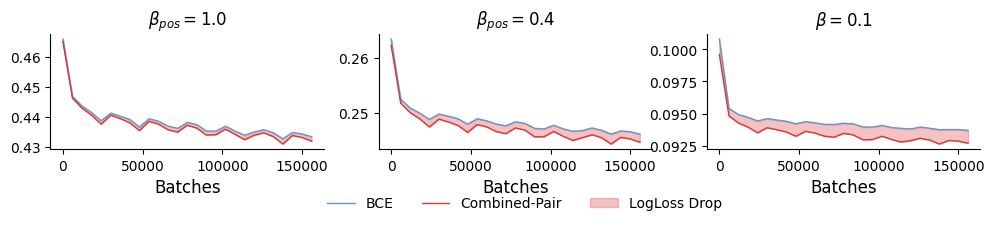

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(12,1.5))  # 1 row, 5 columns
plot_train_logloss(ret_dict4, ret_dict2, r'$\beta={}$'.format(0.1), axs[2])
plot_train_logloss(bce_ret_dicts[1], combined_pair_ret_dicts[1], r'$\beta_{pos}=$'+str(0.4), axs[1])
line1, line2, fill = plot_train_logloss(bce_ret_dicts[4], combined_pair_ret_dicts[4], r'$\beta_{pos}=$'+str(1.0), axs[0])

plt.legend([line1, line2,fill], ['BCE', 'Combined-Pair', 'LogLoss Drop'], bbox_to_anchor=(0.1,-0.3),fontsize=10, ncols=3,frameon=False)
plt.savefig('../../../../figure/loss_cmp_along_beta.pdf',dpi=400,bbox_inches='tight')